# Introduction to the kagglegym API
Located at: https://www.kaggle.com/jeffmoser/two-sigma-financial-modeling/kagglegym-api-overview

The API is exposed through a kagglegym library. Let's import it to get started:

In [1]:
import numpy as np
import pandas as pd
import h5py
import kagglegym
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

%matplotlib inline

Load the downloaded data

In [2]:
with pd.HDFStore("../input/train.h5", "r") as train:
    # Note that the "train" dataframe is the only dataframe in the file
    df = train.get("train")

Now, we need to create an "environment". This will be our primary interface to the API. The kagglegym API has the concept of a default environment name for a competition, so just calling make() will create the appropriate one for this competition.

In [3]:
# Create environment
env = kagglegym.make()

To properly initialize things, we need to "reset" the environment. This will also give us our first "observation":

In [4]:
# Get first observation
observation = env.reset()

Observations are the means by which our code "observes" the world. The very first observation has a special property called "train" which is a dataframe which we can use to train our model:

In [5]:
# Look at first few rows of the train dataframe
observation.train.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338


Note that this "train" is about half the size of the full training dataframe. This is because we're in an exploratory mode where we simulate the full environment by reserving the first half of timestamps for training and the second half for simulating the public leaderboard.

In [6]:
# Get length of the train dataframe
len(observation.train)

806298

In [7]:
# Get the shape of the dataframe
observation.train.shape

(806298, 111)

In [8]:
# Get number of unique timestamps in train
len(observation.train["timestamp"].unique())

906

In [9]:
# Note that this is half of all timestamps:
len(df["timestamp"].unique())

1813

In [10]:
# Here's proof that it's the first half:
unique_times = list(observation.train["timestamp"].unique())
(min(unique_times), max(unique_times))

(0, 905)

Missing Values Plot

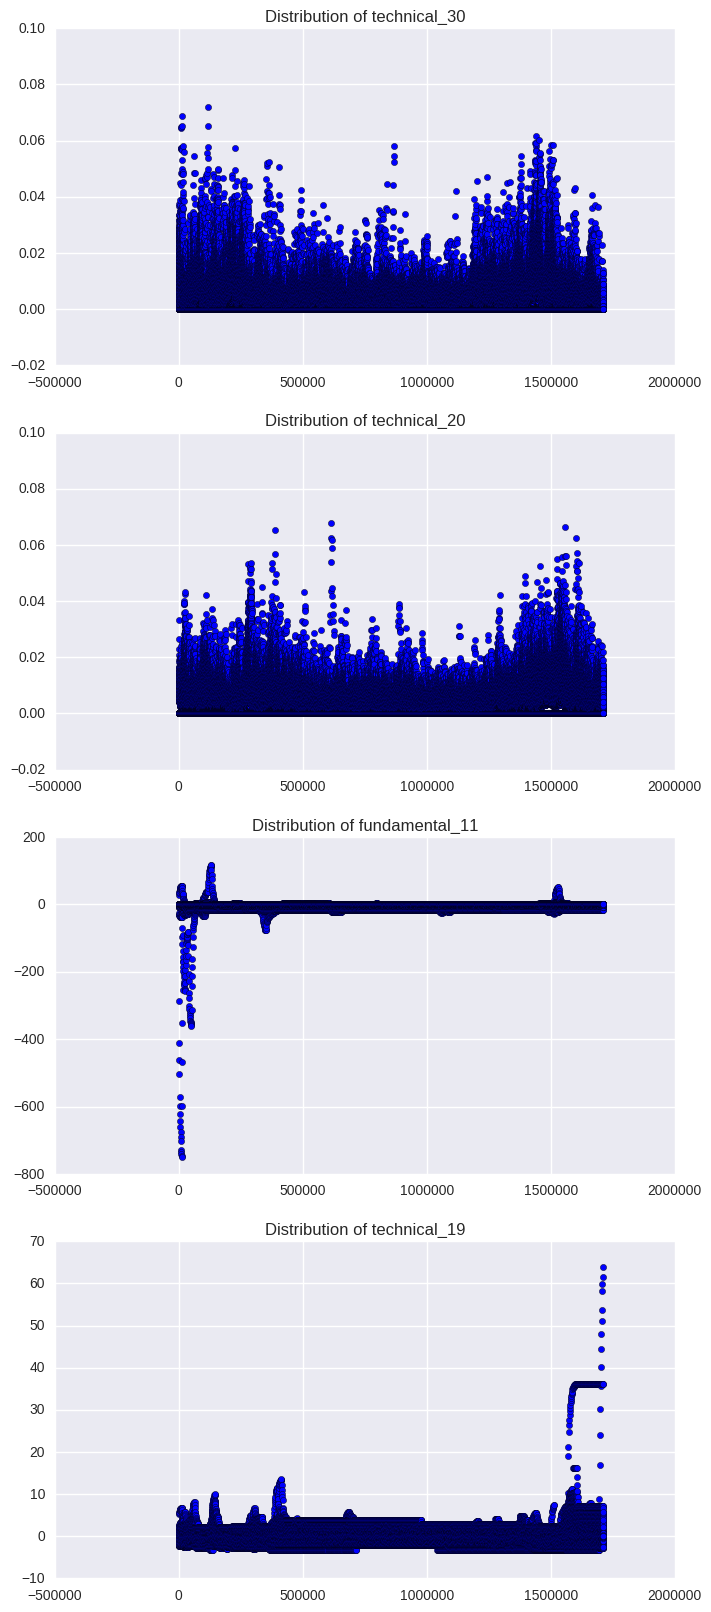

In [11]:
cols_to_use = ['technical_30', 'technical_20', 'fundamental_11', 'technical_19']
fig = plt.figure(figsize=(8, 20))
plot_count = 0
for col in cols_to_use:
    plot_count += 1
    plt.subplot(4, 1, plot_count)
    plt.scatter(range(df.shape[0]), df[col].values)
    plt.title("Distribution of "+col)
plt.show()

Now we can check the 'y' distribution of some of the assets. Let us first look at ids with high negative mean target values.

In [12]:
temp_df = df.groupby('id')['y'].agg('mean').reset_index().sort_values(by='y')
temp_df.head()

,id,y
954,1431,-0.035077
62,93,-0.032797
585,882,-0.015408
1085,1637,-0.014028
742,1118,-0.011848


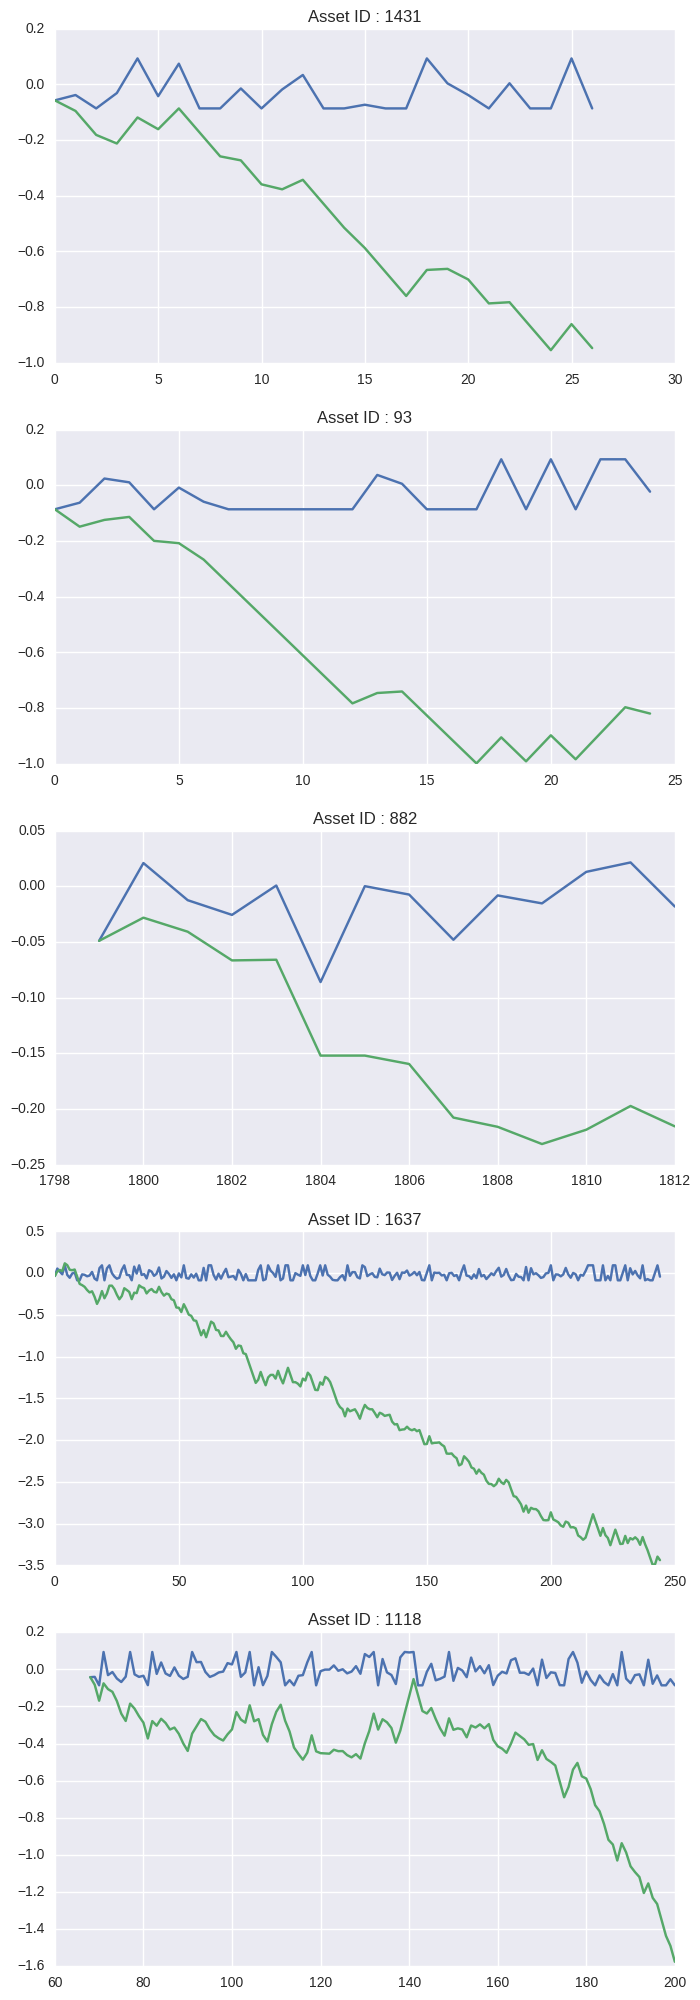

In [13]:
id_to_use = [1431, 93, 882, 1637, 1118]
fig = plt.figure(figsize=(8, 25))
plot_count = 0
for id_val in id_to_use:
    plot_count += 1
    plt.subplot(5, 1, plot_count)
    temp_df = df.ix[df['id']==id_val,:]
    plt.plot(temp_df.timestamp.values, temp_df.y.values)
    plt.plot(temp_df.timestamp.values, temp_df.y.cumsum())
    plt.title("Asset ID : "+str(id_val))
    
plt.show()

Blue line represents the distribution of 'y' variable in the given time stamp. Green line represents the cumulative 'y' value

So 4 out these 5 assets are dropped (as they are not present till the last time stamp which is 1812), when the cumulative negative target value falls steeply.

Now let us take the assets with high positive mean target value and see their distribution.

In [13]:
temp_df = df.groupby('id')['y'].agg('mean').reset_index().sort_values(by='y')
temp_df.tail()

,id,y
506,767,0.006385
148,226,0.006400
545,824,0.006730
1195,1809,0.007290
726,1089,0.010827


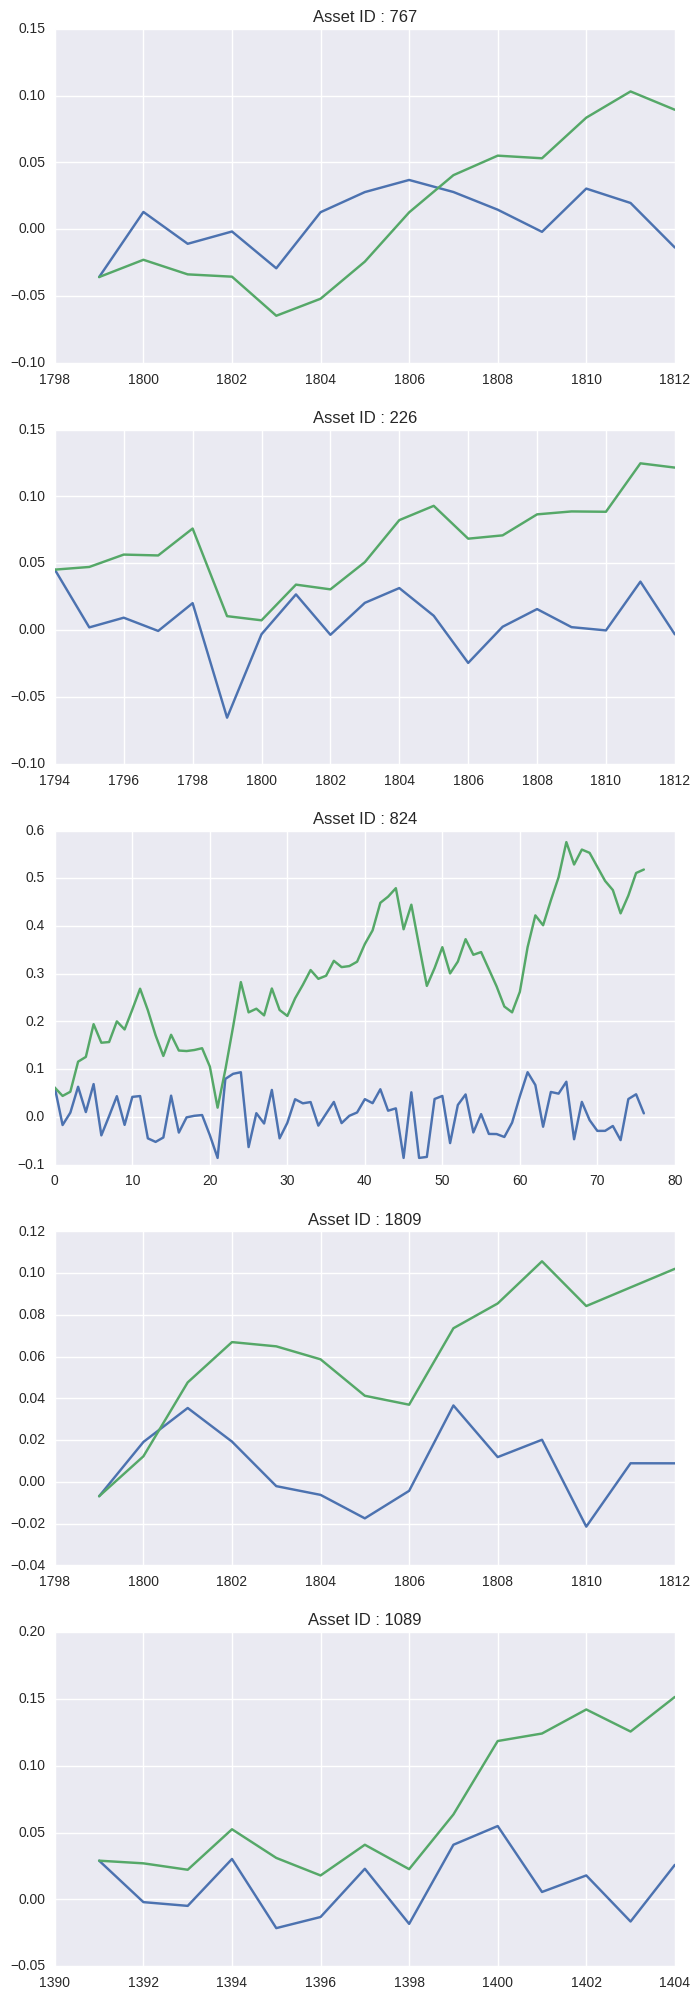

In [14]:
id_to_use = [767, 226, 824, 1809, 1089]
fig = plt.figure(figsize=(8, 25))
plot_count = 0
for id_val in id_to_use:
    plot_count += 1
    plt.subplot(5, 1, plot_count)
    temp_df = df.ix[df['id']==id_val,:]
    plt.plot(temp_df.timestamp.values, temp_df.y.values)
    plt.plot(temp_df.timestamp.values, temp_df.y.cumsum())
    plt.title("Asset ID : "+str(id_val))
plt.show()

Interestingly 2 of these 5 good performing assets are also dropped (Assets 824 and 1089). Not sure about the reasons though.

Now let us take some assets which are present across all the timestamps and see their distribution.

In [15]:
temp_df = df.groupby('id')['y'].agg('count').reset_index().sort_values(by='y')
temp_df.tail()

,id,y
1033,1548,1813
465,699,1813
463,697,1813
469,704,1813
711,1066,1813


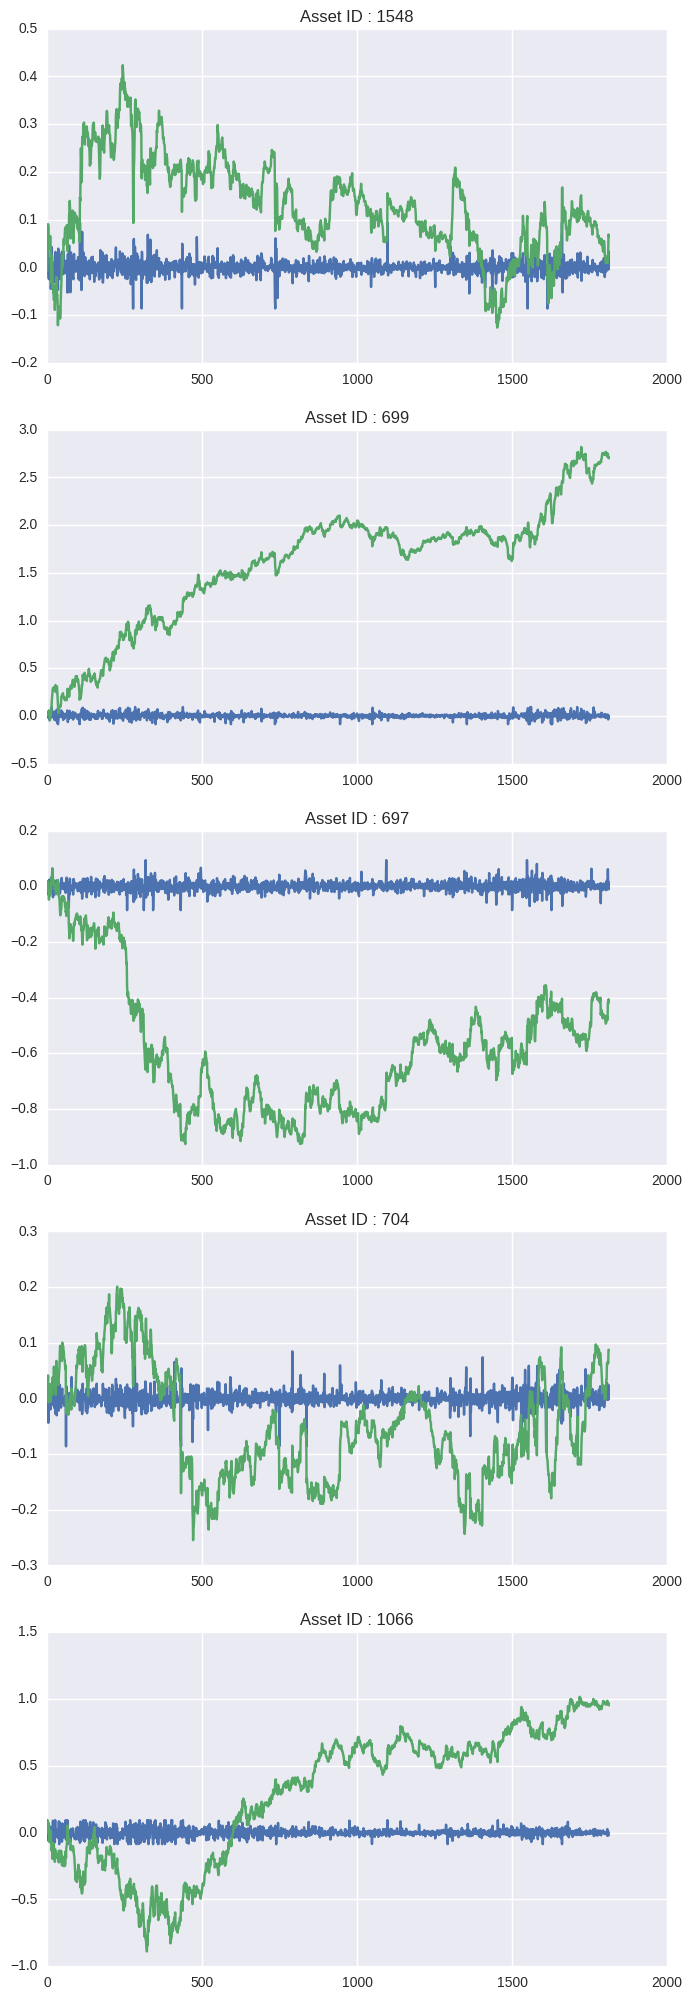

In [16]:
id_to_use = [1548, 699, 697, 704, 1066]
fig = plt.figure(figsize=(8, 25))
plot_count = 0
for id_val in id_to_use:
    plot_count += 1
    plt.subplot(5, 1, plot_count)
    temp_df = df.ix[df['id']==id_val,:]
    plt.plot(temp_df.timestamp.values, temp_df.y.values)
    plt.plot(temp_df.timestamp.values, temp_df.y.cumsum())
    plt.title("Asset ID : "+str(id_val))
plt.show()

Visit to learn why stocks are bought and sold
https://www.kaggle.com/sankhamukherjee/two-sigma-financial-modeling/when-why-are-stocks-bought-and-sold

Fill in the missing data points with the mean

In [14]:
mean_values = observation.train.mean(axis=0)
observation.train.fillna(mean_values, inplace=True)
observation.train.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-6.316399e-03,0.222831,-0.213030,0.729277,-0.335633,1.132921e-01,1.621238,...,0.775208,-0.098557,-0.090948,-0.080027,-0.414776,0.00601,-0.028033,-2.0,0.000783,-0.011753
1,11,0,0.014765,-3.806422e-02,-0.017425,0.320652,-0.034134,0.004413,1.142851e-01,-0.210185,...,0.025590,-0.098557,-0.090948,-0.080027,-0.273607,0.00601,-0.028033,-2.0,0.000783,-0.001240
2,12,0,-0.010622,-5.057707e-02,3.379575,-0.157525,-0.068550,-0.155937,1.219439e+00,-0.764516,...,0.151881,-0.098557,-0.090948,-0.080027,-0.175710,0.00601,-0.028033,-2.0,0.000783,-0.020940
3,25,0,-9.463644,3.195843e+11,-0.835275,-0.856674,37.132420,0.178495,-1.254203e+09,-0.007262,...,1.035936,-0.098557,-0.090948,-0.080027,-0.211506,0.00601,-0.028033,-2.0,0.000783,-0.015959
4,26,0,0.176693,-2.528418e-02,-0.057680,0.015100,0.180894,0.139445,-1.256869e-01,-0.018707,...,0.630232,-0.098557,-0.090948,-0.080027,-0.001957,0.00601,-0.028033,0.0,0.000783,-0.007338


In [15]:
train = observation.train

## Correlation coefficient plot:
Let us look at the correlation of each of the variables with the target variables to get some important variables to be used for our next steps.

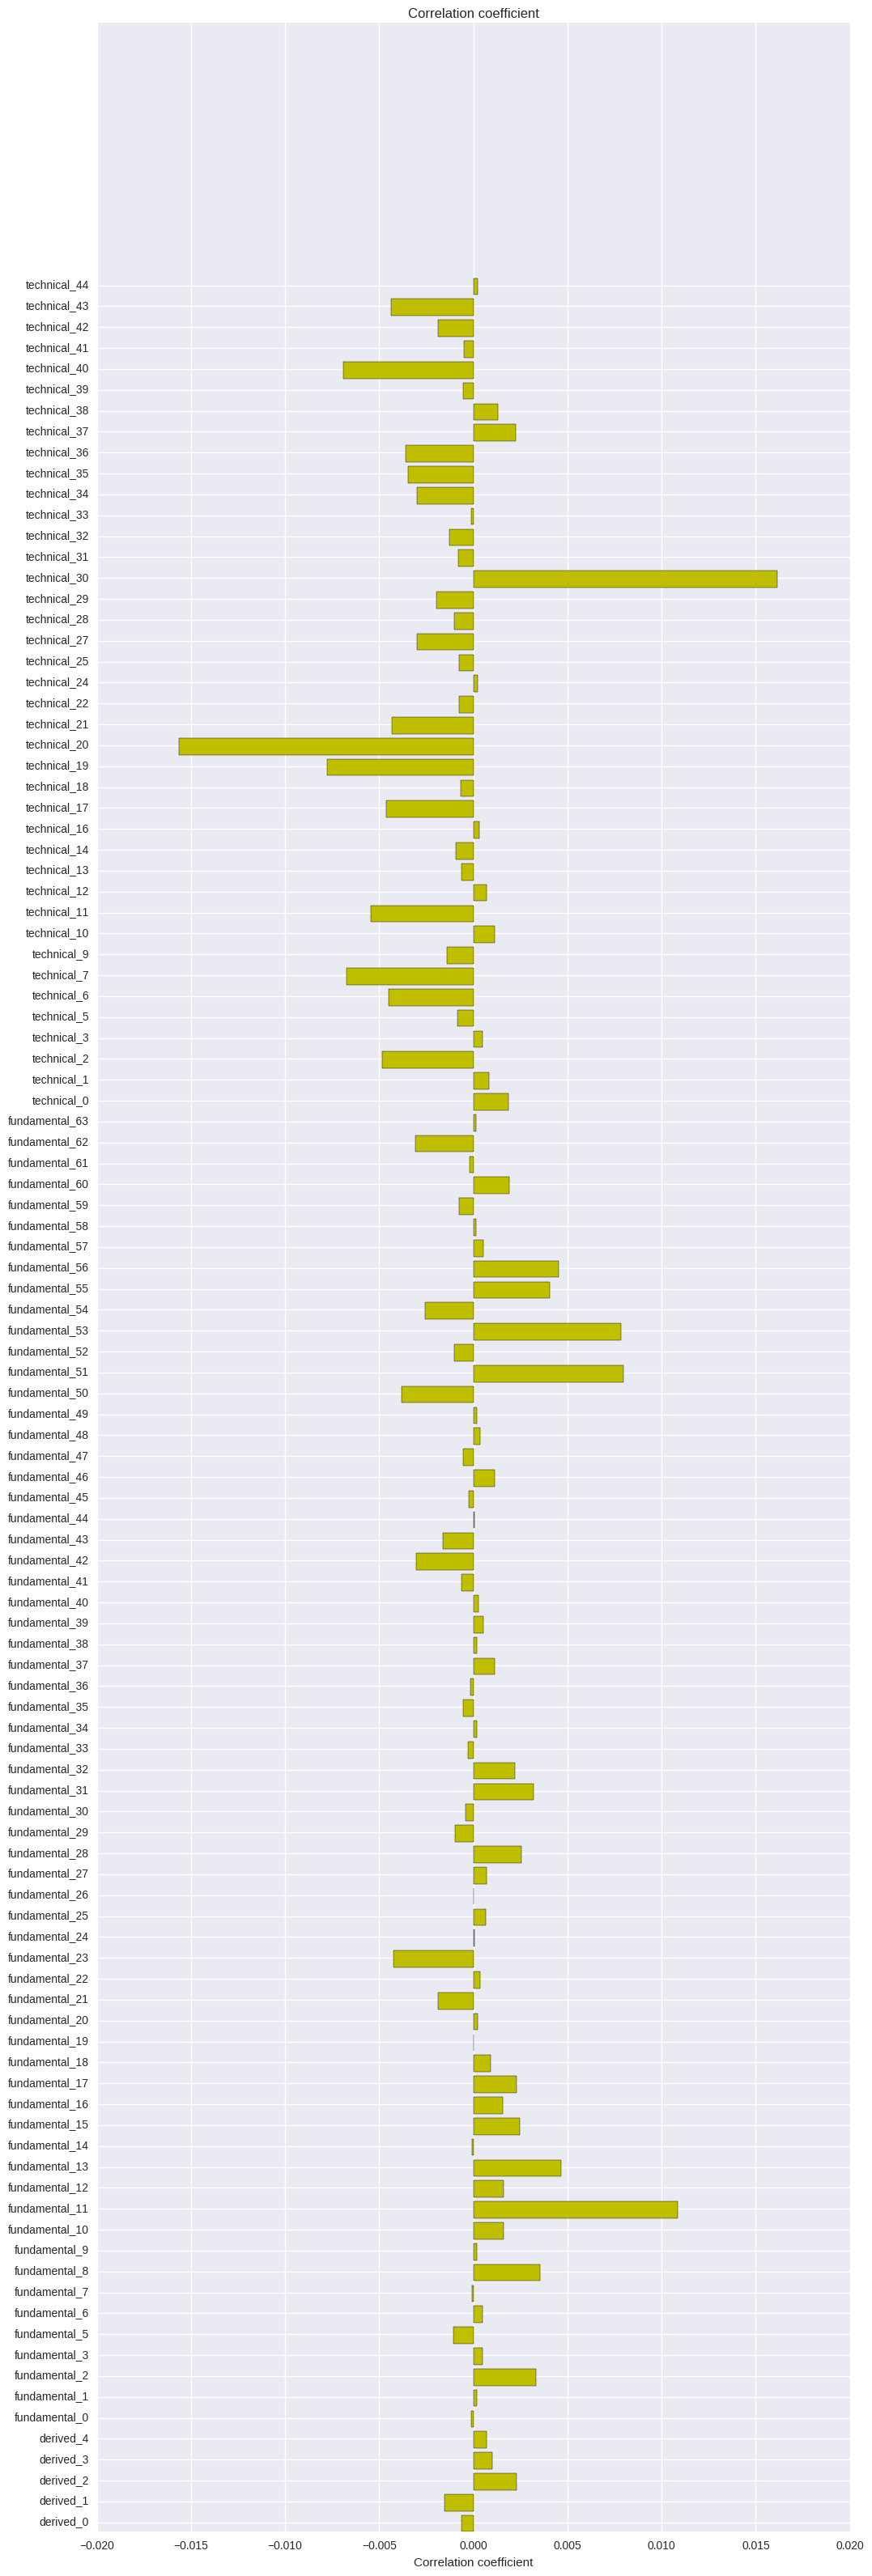

In [16]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train.columns if col not in ['id','timestamp','y']]

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.y.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()

As expected, the correlation coefficient values are very low and the maximum value is around 0.016 (in both positive and negative) as seen from the plot above.
Let us take the top 4 variables from the plot above and do some more analysis on them alone.
- technical_30
- technical_20
- fundamental_11
- technical_19

As a first step, let us get the correlation coefficient in between these variables.

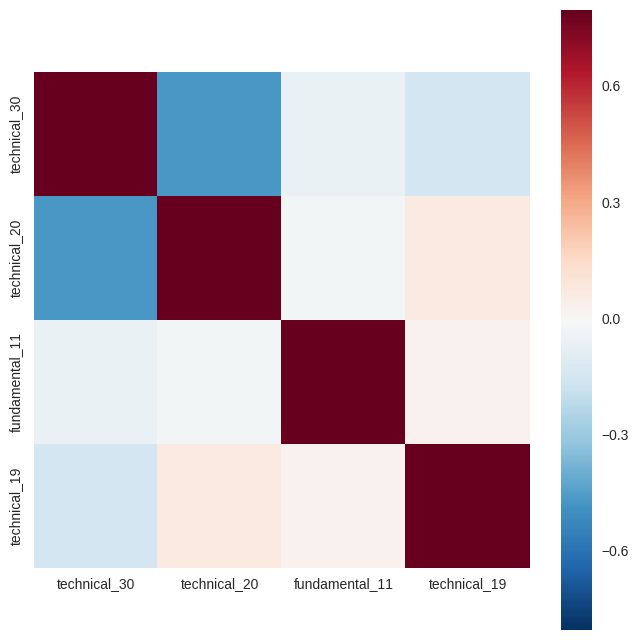

In [17]:
cols_to_use = ['technical_30', 'technical_20', 'fundamental_11', 'technical_19']

temp_df = train[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

There is some negative correlation between 'technical_30' and 'technical_20'.
As the next step, let us build simple linear regression models using these variables alone and see how they perform.

Let us first build our models.

In [18]:
models_dict = {}
for col in cols_to_use:
    model = lm.LinearRegression()
    model.fit(np.array(train[col].values).reshape(-1,1), train.y.values)
    models_dict[col] = model

So we have built 4 univariate models using the train data.

### Technical_30:

So we will start predicting with the model using 'technical_30' variable.

In [17]:
col = 'technical_30'
model = models_dict[col]
while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[col].values).reshape(-1,1)
    observation.target.y = model.predict(test_x)
    #observation.target.fillna(0, inplace=True)
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
        
    observation, reward, done, info = env.step(target)
    if done:
        break
info

NameError: name 'models_dict' is not defined

We are getting a public score of 0.011 using this variable.

### Technical_20:

Now let us predict the test using our second univariate model which we have built.

In [ ]:
# Get first observation
env = kagglegym.make()
observation = env.reset()

col = 'technical_20'
model = models_dict[col]
while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[col].values).reshape(-1,1)
    observation.target.y = model.predict(test_x)
    #observation.target.fillna(0, inplace=True)
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
        
    observation, reward, done, info = env.step(target)
    if done:
        break
info

Using 'technical_20' as input variable, we are getting a public score of 0.0169 which is slightly better than the previous one.

Submitting this model to the LB gave me a score of 0.006. I have exported the above script into a kernel and it can be accessed here: https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/univariate-model

Let us do the same for our last two variables as well.

### Fundamental_11:

In [ ]:
# Get first observation
env = kagglegym.make()
observation = env.reset()

col = 'fundamental_11'
model = models_dict[col]
while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[col].values).reshape(-1,1)
    observation.target.y = model.predict(test_x)
    #observation.target.fillna(0, inplace=True)
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
        
    observation, reward, done, info = env.step(target)
    if done:
        break
info

### Technical_19:

In [ ]:
# Get first observation
env = kagglegym.make()
observation = env.reset()

col = 'technical_19'
model = models_dict[col]
while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[col].values).reshape(-1,1)
    observation.target.y = model.predict(test_x)
    #observation.target.fillna(0, inplace=True)
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
        
    observation, reward, done, info = env.step(target)
    if done:
        break
info

### Regression using all 4 variables:

Now let us build multiple regression model using all these 4 variables.

In [ ]:
cols_to_use = ['technical_30', 'technical_20', 'fundamental_11', 'technical_19']

# Get first observation
env = kagglegym.make()
observation = env.reset()
train = observation.train
train.fillna(mean_values, inplace=True)

model = lm.LinearRegression()
model.fit(np.array(train[cols_to_use]), train.y.values)

while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[cols_to_use])
    observation.target.y = model.predict(test_x)
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
        
    observation, reward, done, info = env.step(target)
    if done:
        break
info

This multiple regression gave a score of 0.019 which is better than all univariate models. So probably submitting this model might give a better LB score.

### Model with Clipping:

As we can see from this script which gives the best public LB score of 0.00911, clipping the 'y' values help.
https://www.kaggle.com/bguberfain/two-sigma-financial-modeling/univariate-model-with-clip/run/482189/code

So let us dig a little deeper to see why the public LB score increased from 0.006 to 0.009 when we clip the 'y' values.

In [ ]:
print("Max y value in train : ",train.y.max())
print("Min y value in train : ",train.y.min())

Let us now do the clipping and see the number of rows that will be discarded from the training.

In [ ]:
low_y_cut = -0.086093
high_y_cut = 0.093497

y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
y_is_within_cut.value_counts()

So there are 9418 rows in the training set that lie between (-0.086093 and -0.0860941) and (0.093497 and 0.0934978) in the training set. So many values in such a small range.

As we can see from anokas script, the distribution of 'y' values have two small spikes at both the ends. Probably values which are higher than these values are clipped in the training data and so not using these rows in our model building might be a good idea. 
https://www.kaggle.com/anokas/two-sigma-financial-modeling/two-sigma-time-travel-eda

Now let us re-train our model (using technical_20) by excluding these rows from the training.

In [ ]:
# Get first observation
env = kagglegym.make()
observation = env.reset()

col = 'technical_20'
model = lm.LinearRegression()
model.fit(np.array(train.loc[y_is_within_cut, col].values).reshape(-1,1), train.loc[y_is_within_cut, 'y'])

while True:
    observation.features.fillna(mean_values, inplace=True)
    test_x = np.array(observation.features[col].values).reshape(-1,1)
    observation.target.y = model.predict(test_x).clip(low_y_cut, high_y_cut)
    #observation.target.fillna(0, inplace=True)
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))
        
    observation, reward, done, info = env.step(target)
    if done:
        break
info

So we got almost same public score of 0.0169 with clip.

But on the leaderboard, we are getting some improvement in the score from 0.006 to 0.009.

Each observation also has a "features" dataframe which contains features for the timestamp you'll be asked to predict in the next "step." Note that these features are for timestamp 906 which is just passed the last training timestamp. Also, note that the "features" dataframe does not have the target "y" column:

In [ ]:
# Look at the first few rows of the features dataframe
observation.features.head()

The final part of observation is the "target" dataframe which is what we're asking you to fill in. It includes the "id"s for the timestamp next step.

In [ ]:
# Look at the first few rows of the target dataframe
observation.target.head()

This target is a valid submission for the step. The OpenAI Gym calls each step an "action". Each step of the environment returns four things: "observation", "reward", "done", and "info".

In [ ]:
# Each step is an "action"
action = observation.target

# Each "step" of the environment returns four things:
observation, reward, done, info = env.step(action)

The "done" variable tells us if we're done. In this case, we still have plenty of timestamps to go, so it returns "False".

In [ ]:
# Print done
done

The "info" variable is just a dictionary used for debugging. In this particular environment, we only make use of it at the end (when "done" is True).

In [ ]:
# Print info
info

We see that "observation" has the same properties as the one we get in "reset". However, notice that it's for the next "timestamp":

In [ ]:
# Look at the first few rows of the observation dataframe for the next timestamp
observation.features.head()

In [ ]:
# Note that this timestamp has more id's/rows
len(observation.features)

Perhaps most interesting is the "reward" variable. This tells you how well you're doing. The goal in reinforcement contexts is that you want to maximize the reward. In this competition, we're using the R value that ranges from -1 to 1 (higher is better). Note that we submitted all 0's, so we got a score that's below 0. If we had correctly predicted the true mean value, we would have gotten all zeros. If we had made extreme predictions (e.g. all -1000's) then our score would have been capped to -1.

In [ ]:
# Print reward
reward

Since we're in exploratory mode, we have access to the ground truth (obviously not available in submit mode):

In [ ]:
perfect_action = df[df["timestamp"] == observation.features["timestamp"][0]][["id", "y"]].reset_index(drop=True)

In [ ]:
# Look at the first few rows of perfect action
perfect_action.head()

Let's see what happens when we submit a "perfect" action:

In [ ]:
# Submit a perfect action
observation, reward, done, info = env.step(perfect_action)

As expected, we get the maximum reward of 1 by submitting the perfect value:

In [ ]:
# Print reward
reward

# Making a complete submission
We've covered all of the basic components of the kagglegym API. You now know how to create an environment for the competition, get observations, examine features, and submit target values for a reward. But, we're still not done as there are more observations/timestamps left.

In [ ]:
# Print done ... still more timestamps remaining
done

Now that we've gotten the basics out of the way, we can create a basic loop until we're "done". That is, we'll make a prediction for the remaining timestamp in the data:

In [ ]:
while True:
    target = observation.target
    timestamp = observation.features["timestamp"][0]
    if timestamp % 100 == 0:
        print("Timestamp #{}".format(timestamp))

    observation, reward, done, info = env.step(target)
    if done:        
        break

Now we can confirm that we're done:

In [ ]:
# Print done
done

And since we're "done", we can take a look at at "info", our dictionary used for debugging. Recall that in this environment, we only make use of it when "done" is True.

In [ ]:
# Print info
info

Our score is better than 0 because we had that one submission that was perfect.

In [ ]:
# Print "public score" from info
info["public_score"]

This concludes our overview of the kagglegym API. We encourage you to ask questions in the competition forums or share public kernels for feedback on your approach. Good luck!